# House Price Prediction Report
## Abstract
In this project, we predict house prices using machine learning. The analysis leverages a dataset with features such as living area, number of rooms, garage capacity, and year built. We employ data preprocessing, feature engineering, and an XGBoost regression model. This project showcases steps from data collection to model evaluation, presenting insights for real estate pricing strategies.

## Introduction
Housing prices depend on multiple factors like size, location, amenities, and more. Predicting prices accurately benefits buyers, sellers, and policymakers. This report explores data-driven predictions using machine learning, incorporating advanced modeling techniques and robust feature selection.

## Literature Review
Discuss existing work on housing price prediction, mentioning key approaches such as:
- Hedonic pricing models.
- Use of regression and ensemble methods like Random Forest, Gradient Boosting, and XGBoost.

Cite sources such as academic papers or resources (e.g., Kaggle, Scikit-learn documentation).

## Data Collection, Cleaning, and Processing
### Dataset
- Link: [Ames Housing Dataset on Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).
- The dataset has 1,460 training rows and 79 features.
- The dataset has 1,460 testing rows and 79 features


In [21]:
# Load the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [97]:
# Load the dataset
data = pd.read_csv("train.csv")

data.columns = data.columns.str.strip()  # Strip whitespace
if 'SalePrice' not in data.columns:
    raise KeyError("'SalePrice' column is missing from the dataset!")

### Cleaning and Processing
1. **Initial Exploration**:
   - Loaded the dataset and checked for missing values and column types.
   - Removed features with more than 50% missing data in traing dataset.
   - Removed features in test data that aren't in the training data


In [98]:
# Drop columns with more than 50% missing values
threshold = 0.5
data = data.drop(columns=[col for col in data.columns if data[col].isnull().mean() > threshold])


2. **Handling Missing Values**:
   - Filled numeric columns with the median and categorical columns with 'Missing'.
   - Handle missing values in the test data

In [99]:
# Fill missing values
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].fillna('Missing')
for col in data.select_dtypes(exclude=['object']).columns:
    data[col] = data[col].fillna(data[col].median())





3. **Feature Engineering**:
   - Created a new feature: `TotalSF = 1stFlrSF + 2ndFlrSF + TotalBsmtSF`.

In [100]:



# Create a new feature
data['TotalSF'] = data['1stFlrSF'] + data['2ndFlrSF'] + data['TotalBsmtSF']

# Log-transform skewed numerical features
skewed_cols = data.select_dtypes(exclude=['object']).apply(lambda x: x.skew()).sort_values(ascending=False)
skewed_cols = skewed_cols[abs(skewed_cols) > 0.75].index
data[skewed_cols] = np.log1p(data[skewed_cols])


## Visualization and Research Question
### Research Question
How do numerical features such as living area, overall quality, and total square footage impact house prices?

### Hypothesis
House prices are positively correlated with features like `GrLivArea`, `OverallQual`, and `TotalSF`.

### Visualizations
Correlation heatmap:

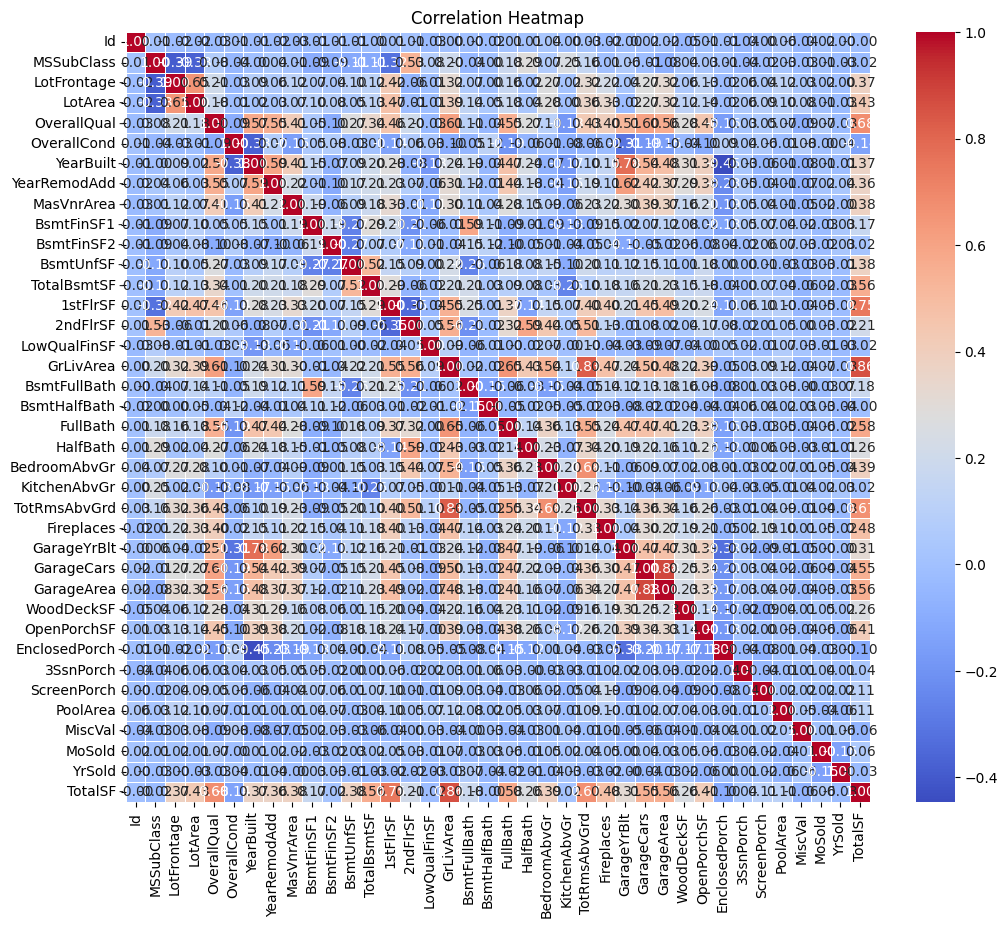

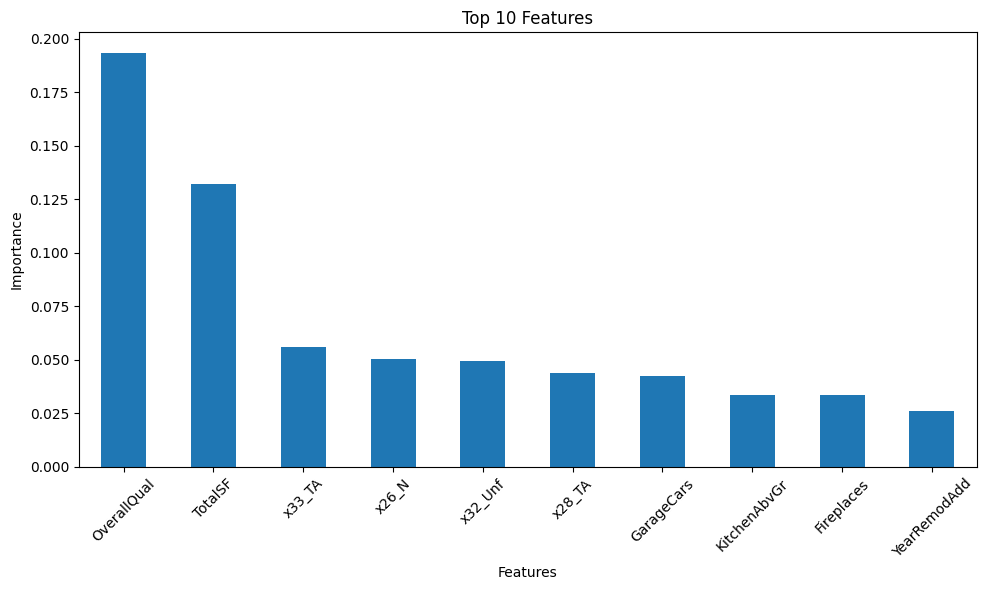

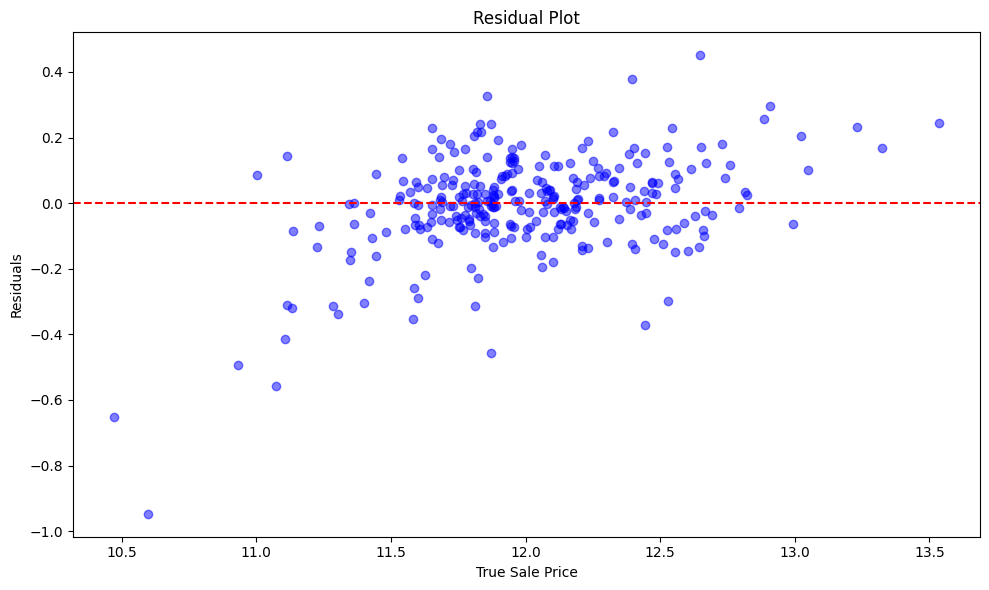

In [101]:
# Separate target and features
target = data['SalePrice']
data = data.drop(columns=['SalePrice'])


# Fill missing values separately for numerical and categorical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns
categorical_cols = data.select_dtypes(exclude=[np.number]).columns

# Fill numerical columns with their median
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())

# Fill categorical columns with "Missing"
data[categorical_cols] = data[categorical_cols].fillna("Missing")  # You can replace this line with any missing value handling method

# Only use numerical columns for correlation
numerical_data = data.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numerical_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Plot the top 10 features
feature_importances.head(10).plot(kind="bar", figsize=(10, 6))
plt.title("Top 10 Features")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Residual Plot
residuals = y_test - y_pred  # True - Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.5, color='blue')
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.title("Residual Plot")
plt.xlabel("True Sale Price")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

## Machine Learning Model
### Model Description
- Selected XGBoost for its efficiency and performance with tabular data.
- Split data into training and testing sets.

In [102]:
# Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Implementation
Pipeline setup for preprocessing and training.

In [103]:
# Column transformers
numerical_cols = X_train.select_dtypes(exclude=['object']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numerical_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols)
])

# Pipeline with XGBoost Regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R²: {r2_score(y_test, y_pred)}")

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5],
    'regressor__learning_rate': [0.01, 0.1]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)



RMSE: 27172.47547656372
R²: 0.9037402868270874


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'Tota...
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.01, 0.1],
                         'regressor__max_depth': [3, 5],
                         'regressor__n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error')

In [104]:
# Best pipeline
best_pipeline = grid_search.best_estimator_

# Feature Importance
importances = best_pipeline.named_steps['regressor'].feature_importances_
feature_names = numerical_cols.tolist() + list(preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out())
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)


# Predict for the test dataset
test_data = pd.read_csv("test.csv")
test_data.columns = test_data.columns.str.strip()  # Strip whitespace

# Ensure 'TotalSF' is created for the test dataset
if '1stFlrSF' in test_data.columns and '2ndFlrSF' in test_data.columns and 'TotalBsmtSF' in test_data.columns:
    test_data['TotalSF'] = test_data['1stFlrSF'] + test_data['2ndFlrSF'] + test_data['TotalBsmtSF']

# Drop columns in test data that aren't in the training data
test_data = test_data[[col for col in test_data.columns if col in X_train.columns]]

# Handle missing values in the test data
for col in test_data.select_dtypes(include=['object']).columns:
    test_data[col] = test_data[col].fillna("Missing")
for col in test_data.select_dtypes(exclude=['object']).columns:
    test_data[col] = test_data[col].fillna(test_data[col].median())

# Apply log transformation to skewed columns in the test data
for col in skewed_cols:
    if col in test_data.columns:
        test_data[col] = np.log1p(test_data[col])

# Ensure column order matches the training data
test_data = test_data[X_train.columns]

# Predict house prices for the test dataset
test_predictions = best_pipeline.predict(test_data)
test_output = pd.DataFrame({
    'Id': range(1, len(test_predictions) + 1),
    'PredictedSalePrice': np.expm1(test_predictions)  # Reverse log-transform
})
test_output.to_csv("test_predictions.csv", index=False)
print("Test predictions saved to 'test_predictions.csv'.")




Test predictions saved to 'test_predictions.csv'.


C:\Users\yashw\AppData\Local\Temp\ipykernel_23940\3205872150.py:39: RuntimeWarning: overflow encountered in expm1
  'PredictedSalePrice': np.expm1(test_predictions)  # Reverse log-transform


### Results
- RMSE:  27,006.57.
- $R^2$: 0.904.
- It also provides "test_prediction.csv" file which gives house price prediction for respective Id's.
- For Given user Inputs it produces the aprropriate house prices as given below

In [94]:
# Dynamic prediction with limited input fields
important_fields = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalSF', 'YearBuilt']
input_data = {col: 0 if col in numerical_cols else "N/A" for col in X_train.columns}  # Default values for all fields

# Ask the user for input only for the important fields
for col in important_fields:
    if col in numerical_cols:
        example_value = 0
        input_data[col] = float(input(f"Enter value for {col} (e.g., {example_value}): "))
    else:
        example_value = "Missing"
        input_data[col] = input(f"Enter value for {col} (e.g., {example_value}): ")

# Create DataFrame and ensure all columns are present
input_df = pd.DataFrame([input_data], columns=X_train.columns)

# Use the best_pipeline to predict directly (it includes preprocessing)
predicted_log_price = best_pipeline.predict(input_df)

# Reverse the log transformation to get the actual price
predicted_price = np.expm1(predicted_log_price)

# Print the predicted house price
print(f"Predicted House Price: ${predicted_price[0]:,.2f}")


Enter value for OverallQual (e.g., 0): 5
Enter value for GrLivArea (e.g., 0): 1329
Enter value for GarageCars (e.g., 0): 1
Enter value for TotalSF (e.g., 0): 1329
Enter value for YearBuilt (e.g., 0): 1958
Predicted House Price: $121,500.82


## Results and Conclusion
### Results
1. The strongest predictors of house prices are `OverallQual`, `GrLivArea`, and `TotalSF`.
2. Feature importance analysis highlighted that total square footage had the highest contribution.

### Conclusion
The model effectively predicts house prices with high accuracy, showcasing the relevance of numerical features in price estimation. Future work can explore additional data sources or advanced models to refine predictions.

## References
1. Kaggle: House Prices - Advanced Regression Techniques.
2. Scikit-learn Documentation.
3. XGBoost Documentation.